## LSTM for lag

- p5a: Copied from https://cmsdk.com/python/lstm--learn-a-simple-lag-in-the-data.html
- p5b: my fixes
- p5c: Use LSTM-based AE (i.e. no output, just unsupervised dimensionality reduction)
- p5d: LSTM-based AE made more efficient?
- p5e: LSTM-based AE on GPU + middle encoding layer
- p5f: remove dropout and use optimizer=nadam
- p5g: LSTM-60-20-1-20-60, LSTM-60-20-2-20-60

Other references
  - some LSTM AE code in Keras [issue 1401](https://github.com/fchollet/keras/issues/1401#issuecomment-309443122)
    - http://colah.github.io/posts/2015-08-Understanding-LSTMs/
  - https://github.com/fchollet/keras/issues/5138#issuecomment-274893934

### below model results summary

with enc_dim=1 (using Dense layer):
-    loss reaches 0.70 in  50 epochs and slows down dramatically, prediction does not display lags

with enc_dim=None:
-    loss reaches 0.01 in 150 epochs, prediction displays lags

with enc_dim=10 (using Dense layer):
- Epoch 65/200: 6s - loss: 0.1557 - val_loss: 0.1536
  - predictions do not display lags
  
with enc_dim=10 (using LSTM layer):
- Epoch 107/200 - loss: 0.0772 - val_loss: 0.0786
  - 1st 2 predicted features display lag, 3rd feature still negligible
- Epoch 107+200/200 - loss: 0.0714 - val_loss: 0.0711
  - 1st 2 predicted features display lag, 3rd feature still negligible
  
add dropout
- Epoch 67/200 - loss: 0.1838 - val_loss: 0.1620
  - no visible correlations

Tried and failed to make it more efficient
- with enc_dim != None,
  - try to pretrain without the intermediate stacked LSTM
  - then train with it
  - ref: https://stackoverflow.com/a/41661229/4126114
- cannot instantiate network without encoding layer, train, instantiate with encoding, copy weights, train
  - because the input to the output layer is different in these 2 cases
  - will try to just freeze the encoding layer with `rnn_model.trainable = False` and train, then set to True, and train
  - will also need to see if this is really more efficient  

Run on GPU
- super fast
- enc_dim = 10, data length = 100e3
  - Epoch 50+27/300   8s - loss: 0.2472 - val_loss: 0.2166
    - reconstructed features 1 & 2 display lag, but 3 doesnt and is still small
  - epoch 27+50+50+63    8s - loss: 0.1118 - val_loss: 0.0896
    - features 1 & 2 lag is better, but 3 still not
  - Epoch 27+50+50+63+50/300   8s - loss: 0.0995 - val_loss: 0.0825
    - features 1 & 2 lag is almost perfect, but 3 still negligible

Use nadam and remove dropout
- [nadam](https://keras.io/optimizers/) says something about adam and momentum.
    - note that the [keras docs](https://keras.io/getting-started/sequential-model-guide/) on stacked lstm just use rmsprop
    - "in my experience, adam is better than rmsprop" ([ref](https://github.com/fchollet/keras/issues/1401#issuecomment-169295237))
- Epoch 64/300    8s - loss: 0.0770 - val_loss: 0.0843

LSTM-20-20
- Epoch 40/300     6s - loss: 0.0239 - val_loss: 0.0207
  - features 1 & 2 display lag very well, feature 3 is starting to display lag
- Epoch 24/300     6s - loss: 0.0056 - val_loss: 0.0049

Use `optimizer = Nadam(lr=1, schedule_decay=0.0)`
- is this like increasing gradient step size?

LSTM-20-1-20
- reached 0.73 after 40 epochs
- seems to have plateaud

LSTM-1
- Epoch 41/300    2s - loss: 0.6639 - val_loss: 0.6722
- seems to have plateaud

LSTM-60 + LSTM-1 + LSTM-60
- after 300 epochs, loss = 0.69

LSTM-20-20, optimizer = adam
- Epoch 44/300     6s - loss: 0.0144 - val_loss: 0.0134
- Epoch 75/300     6s - loss: 0.0032 - val_loss: 0.0037
- reconstructed features are very very close to originals (with display of lag)

LSTM-60-20-60, optimizer = adam
- Epoch 39/300    20s - loss: 0.0051 - val_loss: 0.0041
- R2 = 0.997 (reconstructed features show lag)

LSTM-60-20-1-20-60, optimizer = adam
- Epoch 14/300    24s - loss: 0.3688 - val_loss: 0.3734
  - R2 = 0.45
  - some visible lag, but still early to see
- Epoch 14+10/300    24s - loss: 0.2828 - val_loss: 0.2925
  - single encoded feature still not meaningful
- Epoch 14+10+20/300    23s - loss: 0.1952 - val_loss: 0.1926
  - R2 = 0.58
  - more visible lag, but still 3rd feature is negligible
  - single encoded feature starting to look like the single important component
- Epoch 14+10+20+41/300    24s - loss: 0.1209 - val_loss: 0.1116
  - R2 = 0.63
  - first 2 features correlation is visible, last feature yet to see
  - encoded feature yet to become more like single component
- Epoch 14+10+20+41+6/300    24s - loss: 0.1066 - val_loss: 0.1064
- Epoch 14+10+20+41+6+116/300  24s - loss: 0.0670 - val_loss: 0.0691
  - R2 = 0.6
  - first 2 feature correlation visible, 3rd feature negligible
  - encoded feature not trustworthy because in/out not perfectly replicated

LSTM-60-20-2-20-60
- Epoch 300/300 72s - loss: 0.0011 - val_loss: 7.8084e-04
- R2 = 0.9992
- got 2 encoded features that don't look lagged

LSTM-60-20-3-20-60
- Epoch 300/300   55s - loss: 6.3800e-04 - val_loss: 3.0157e-04
- R2 = 0.9998
- got 3 encoded features that don't look lagged

LSTM-60-20-4-20-60
- Epoch 300/300  39s - loss: 7.3666e-04 - val_loss: 9.2248e-04
- R2 = 0.9995
- got 4 encoded features that don't look lagged

LSTM-60-20-10-5-1-5-10-20-60
- Reconstruction got 2 features well, but 3rd feature stayed flat
- Epoch 300/300   30s - loss: 0.0677 - val_loss: 0.0688
- R2 = 0.666441571972

LSTM-20-2-20
- 300 epochs, loss = 0.60
- R2 = 0.2

LSTM-60-2-60
- 300 epochs, loss = 0.56
- R2 = 0.25

AE-60-20-2-20-60
- IN PROGRESS

In [1]:
# import os
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
import keras
def strided_app(a, L, S ):  #To get X in the right format expected by Keras
    nrows = ((a.size-L)//S)+1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a, shape=(nrows,L), strides=(S*n,n))

import utils
import utils2

Using TensorFlow backend.


model (99998, 3)


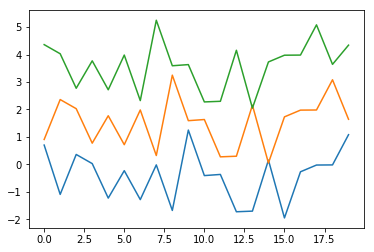

calib (99989, 10, 3)


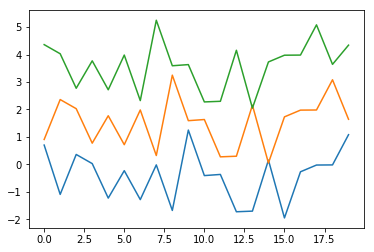

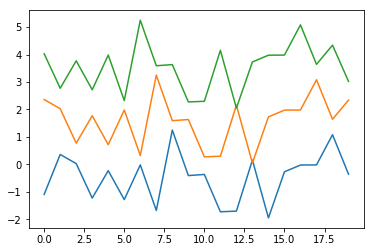

In [2]:
nb_samples = int(100e3) # FIXME # 100e3
X = np.random.randn(nb_samples)
# generate data with 3-lag correlation: X(t-1), X(t), and X(t+1)
timesteps = 3

X_model = strided_app(X, timesteps, 1)
print('model', X_model.shape)
utils.myPlot(X_model[:20],2)

# The first striding above was done in order to generate the input data with a built-in lag relationship
# Now need to stride again because we need to pretend that we do not know that the input has this correlation
# Without this re-striding, it's like telling the model to get y=X
look_back = 10
X_calib      = utils2._load_data_strides(X_model,       n_prev=look_back)
print('calib', X_calib.shape)
utils.myPlot(X_calib[:20,0,:],2) # same as earlier plot
utils.myPlot(X_calib[:20,1,:],2) # lagged version of above plot

In [3]:
# SPLIT train/validation/test
nb_samples_calib = X_calib.shape[0]
nb_train = int(nb_samples_calib * 0.7)
nb_val = int(nb_samples_calib * 0.85)
# strided version
Xc_train = X_calib[: nb_train]
Xc_validation = X_calib[nb_train : nb_val]
Xc_test = X_calib[nb_val:]
# unstrided version
Xm_train = X_model[: nb_train]
Xm_validation = X_model[nb_train : nb_val]
Xm_test = X_model[nb_val:]

print('strided',   Xc_train.shape, Xc_validation.shape, Xc_test.shape)
print('unstrided', Xm_train.shape, Xm_validation.shape, Xm_test.shape)

strided (69992, 10, 3) (14998, 10, 3) (14999, 10, 3)
unstrided (69992, 3) (14998, 3) (15008, 3)


In [4]:
# Note 1: no dropout
# Note 2: add encoded dimension
# Using build_lstm_vanilla with enc_dim doesn't work as the output features cannot be lagged from each other
#    with enc_dim = 1, and no LSTM after enc_dim: until epoch=100, loss: 0.6737 - val_loss: 0.6645
#                                                 until epoch=200, loss: 0.6724 - val_loss: 0.6615
#enc_dim = 1
#model = utils2.build_lstm_vanilla(in_neurons=Xc_train.shape[2], out_neurons=Xm_train.shape[1], lstm_dim=20, enc_dim=enc_dim)

from keras.optimizers import Nadam
lstm_dim = 60 # FIXME 60 20
enc_dim = [20,2,20] # FIXME 10 1 None 20
optimizer = 'adam' # FIXME Nadam(lr=1, schedule_decay=0.0) # lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
model = utils2.build_lstm_ae(in_neurons=Xc_train.shape[2], lstm_dim=lstm_dim, look_back=look_back, enc_dim=enc_dim, optimizer=optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 60)          15360     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 20)          6480      
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 2)           184       
_________________________________________________________________
lstm_4 (LSTM)                (None, 20)                1840      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 20)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 10, 60)            19440     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 3)             183       
Total para

In [5]:
epochs = 300 # FIXME # 100

#weights_path = 'weights.h5'
#early_stopping = EarlyStopping(monitor='val_loss',
#                           patience=100)
#checkpointer = ModelCheckpoint(filepath=weights_path,
#                           verbose=2,
#                           save_best_only=True)
#callbacks = [early_stopping, checkpointer]
history = model.fit(Xc_train,
                    Xc_train, # the TimeDistributed in the model allows me to train again Xc instead of Xm
                    epochs = epochs, # FIXME # 10000,
                    callbacks = [], #callbacks,
                    verbose = 2,
                    # since stateless, make sure this is larger than the look-back=10 and the generated lag=3
                    batch_size = 500, # FIXME # 100
                    validation_data = (Xc_validation,
                                       Xc_validation),
                    shuffle = True)


Train on 69992 samples, validate on 14998 samples
Epoch 1/300
25s - loss: 0.8593 - val_loss: 0.7981
Epoch 2/300
25s - loss: 0.7485 - val_loss: 0.7004
Epoch 3/300
24s - loss: 0.6750 - val_loss: 0.6365
Epoch 4/300
26s - loss: 0.6014 - val_loss: 0.5783
Epoch 5/300
39s - loss: 0.5529 - val_loss: 0.5094
Epoch 6/300
53s - loss: 0.4981 - val_loss: 0.4651
Epoch 7/300
57s - loss: 0.4450 - val_loss: 0.4197
Epoch 8/300
64s - loss: 0.4003 - val_loss: 0.3746
Epoch 9/300
71s - loss: 0.3674 - val_loss: 0.3649
Epoch 10/300
72s - loss: 0.3406 - val_loss: 0.3183
Epoch 11/300
71s - loss: 0.3158 - val_loss: 0.3040
Epoch 12/300
72s - loss: 0.2881 - val_loss: 0.2621
Epoch 13/300
72s - loss: 0.2621 - val_loss: 0.2751
Epoch 14/300
72s - loss: 0.2396 - val_loss: 0.2101
Epoch 15/300
72s - loss: 0.2158 - val_loss: 0.2159
Epoch 16/300
72s - loss: 0.2068 - val_loss: 0.1852
Epoch 17/300
72s - loss: 0.1855 - val_loss: 0.1894
Epoch 18/300
72s - loss: 0.1778 - val_loss: 0.1738
Epoch 19/300
72s - loss: 0.1728 - val_los

72s - loss: 0.0023 - val_loss: 0.0023
Epoch 161/300
71s - loss: 0.0022 - val_loss: 0.0022
Epoch 162/300
72s - loss: 0.0022 - val_loss: 0.0024
Epoch 163/300
72s - loss: 0.0022 - val_loss: 0.0026
Epoch 164/300
71s - loss: 0.0022 - val_loss: 0.0021
Epoch 165/300
72s - loss: 0.0022 - val_loss: 0.0011
Epoch 166/300
72s - loss: 0.0023 - val_loss: 0.0013
Epoch 167/300
72s - loss: 0.0020 - val_loss: 0.0024
Epoch 168/300
71s - loss: 0.0022 - val_loss: 0.0012
Epoch 169/300
71s - loss: 0.0020 - val_loss: 0.0021
Epoch 170/300
72s - loss: 0.0021 - val_loss: 0.0017
Epoch 171/300
72s - loss: 0.0021 - val_loss: 0.0031
Epoch 172/300
72s - loss: 0.0020 - val_loss: 0.0022
Epoch 173/300
71s - loss: 0.0021 - val_loss: 0.0028
Epoch 174/300
72s - loss: 0.0019 - val_loss: 0.0024
Epoch 175/300
72s - loss: 0.0020 - val_loss: 0.0023
Epoch 176/300
72s - loss: 0.0020 - val_loss: 0.0014
Epoch 177/300
72s - loss: 0.0019 - val_loss: 0.0038
Epoch 178/300
72s - loss: 0.0021 - val_loss: 0.0015
Epoch 179/300
72s - loss: 

In [6]:
# history.history['loss']

X (69992, 10, 3) Y (69992, 3) pred (69992, 10, 3)
reshaped pred (69992, 3)


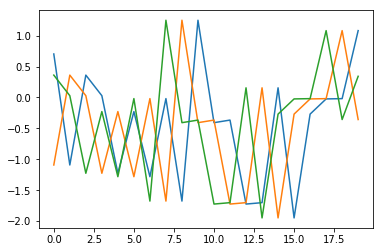

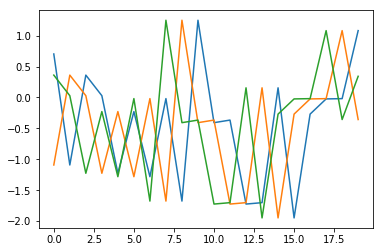

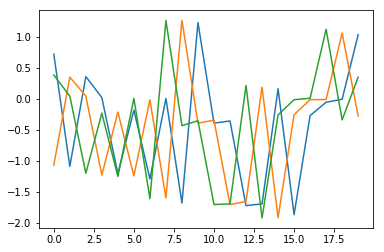

0.999249388756
X (14998, 10, 3) Y (14998, 3) pred (14998, 10, 3)
reshaped pred (14998, 3)


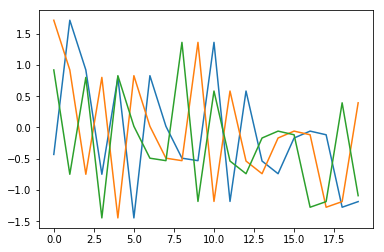

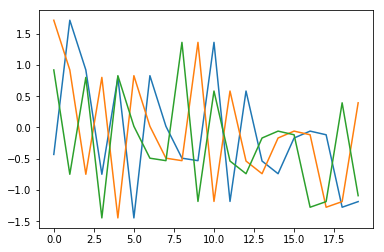

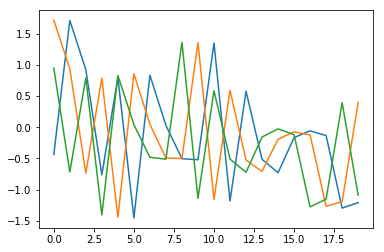

0.999206807264


In [9]:
from matplotlib import pyplot as plt
def myPlot(X):
    plt.plot(X)
    plt.show()

#def R2(X, Y, model):
#    Y_mean = np.mean(Y, axis=0)
#    pred = model.predict(X)
#    res = np.sum(np.square(Y - pred))
#    tot = np.sum(np.square(Y - Y_mean))
#    r2 = 1 - res / tot
#    return r2

def R2(X, Y, model):
    Y_mean = np.mean(Y, axis=0)
    pred = model.predict(X)
    print('X', X.shape, 'Y', Y.shape, 'pred', pred.shape)
    #pred = pred.reshape(Y.shape[0])
    pred = pred[:,0,:]
    print('reshaped pred', pred.shape)
    res = np.sum(np.square(Y - pred))
    tot = np.sum(np.square(Y - Y_mean))
    r2 = 1 - res / tot
    myPlot(X[:20,0])
    myPlot(Y[:20])
    myPlot(pred[:20])
    return r2

#model.load_weights(weights_path)
print(R2(Xc_train,      Xm_train,      model))
print(R2(Xc_validation, Xm_validation, model))
# some dimensionality problems
# print(R2(Xc_test,       Xm_test,       model))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1_input (InputLayer)    (None, None, 3)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 60)          15360     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 20)          6480      
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 2)           184       
Total params: 22,024
Trainable params: 22,024
Non-trainable params: 0
_________________________________________________________________
(14999, 10, 3) (15008, 3) (14999, 10, 2)


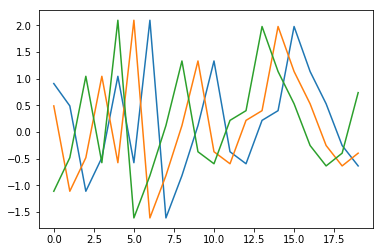

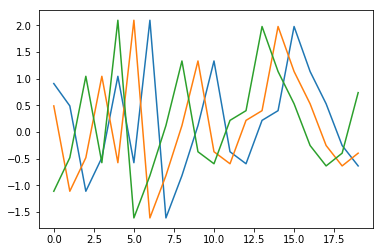

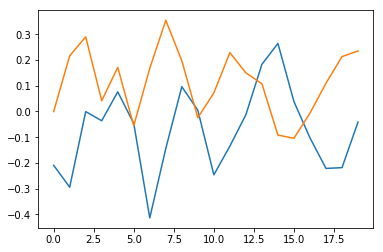

In [10]:
# check encoded signal: expect detection of 1 of the lagged features in X
from keras.models import Model
lstm_enc = Model(inputs=model.input, outputs=model.layers[2].output)
lstm_enc.compile(loss="mean_squared_error", optimizer="rmsprop")
lstm_enc.summary()

X_enc = lstm_enc.predict(Xc_test)
print(Xc_test.shape, Xm_test.shape, X_enc.shape)
utils.myPlot(Xc_test[:20,0,:],0)
utils.myPlot(Xm_test[:20],0)
utils.myPlot(X_enc[:20,0],0)